In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

In [10]:
import utils as ut
early_stopping = ut.EarlyStopping(patience=300, verbose=1)

seed_int = 123
rng = np.random.RandomState(seed_int)

# 1. Create Data for Toy Problem

1.25821617525


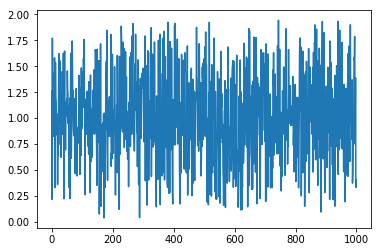

In [3]:
def mask(T=200):
    mask = np.zeros(T)
    indices = rng.permutation(np.arange(T))[:2] # create a permutation and select the first 2 indices
    mask[indices] = 1 # set them to 1
    return mask

def toy_problem(N=10, T=200):
    signals = rng.uniform(low=0.0, high=1.0, size=(N, T))
    masks = np.zeros((N, T))
    for i in range(N):
        masks[i] = mask(T)
    data = np.zeros((N, T, 2))
    data[:, :, 0] = signals[:]
    data[:, :, 1] = masks[:]
    target = (signals*masks).sum(axis=1).reshape(N, 1)
    return (data, target)

def mAdd(Xt):
    return np.sum(Xt[:, 0]*Xt[:, 1])

#print(mAdd(data[0, :, :]))

N=1000
T=200
maxlen = T
X, Y = toy_problem(N=N, T=T)
N_train = int(N*0.9)
N_validation = N-N_train
X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, test_size=N_validation, random_state=seed_int)

print(mAdd(X[0, :, :]))
plt.plot(Y)

# 3. Prepare Model Functions for Graph

In [4]:
def aweight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.Variable(initial, name=name)
    
def abias_variable(shape, name=None):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial, name=name)

def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)
    
def bias_variable(shape, name=None, init_fun=tf.zeros):
    initial = init_fun(shape, dtype=tf.float32)
    return tf.get_variable(name, dtype=tf.float32, initializer=initial)

In [7]:

def infere_lstm(x, n_batch, maxlen=None, n_hidden=None, n_out=None, 
                n_in=None):
    V = weight_variable([n_hidden, n_out], 'V')
    c = bias_variable([n_out], 'c')

    with tf.variable_scope('LSTM'):
        # going to combine this as (x, U)
        # INPUT UNITS
        Ui = weight_variable([n_in, n_hidden], 'Ui') 
        Wi = weight_variable([n_hidden, n_hidden], 'Wi')
        Vi = weight_variable([n_hidden, n_hidden], 'Vi')
        bi = bias_variable([n_hidden], 'bi')
        # OUTPUT UNITS
        Uo = weight_variable([n_in, n_hidden], 'Uo') 
        Wo = weight_variable([n_hidden, n_hidden], 'Wo')
        Vo = weight_variable([n_hidden, n_hidden], 'Vo')
        bo = bias_variable([n_hidden], 'bo')
        # FORGET UNITS
        Uf = weight_variable([n_in, n_hidden], 'Uf') 
        Wf = weight_variable([n_hidden, n_hidden], 'Wf')
        Vf = weight_variable([n_hidden, n_hidden], 'Vf')
        bf = bias_variable([n_hidden], 'bf', init_fun=tf.ones) # limit of the RNN is recovered for f=1, i.e. large bias
        # NEW MEMORY UNITS ('activation' units)
        Ua = weight_variable([n_in, n_hidden], 'Ua') 
        Wa = weight_variable([n_hidden, n_hidden], 'Wa')
        ba = bias_variable([n_hidden], 'ba')
        # Initialize lists
        hlist = []
        clist = []
      
        h_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        c_prev = tf.zeros([n_batch, n_hidden], dtype=tf.float32)
        for i in range(maxlen):
            if i > 0:
                tf.get_variable_scope().reuse_variables()
                h_prev = hlist[-1]
                c_prev = clist[-1]
            a_i = tf.tanh(   tf.matmul(x[:, i, :], Ua) + tf.matmul(h_prev, Wa)                         + ba)
            f_i = tf.sigmoid(tf.matmul(x[:, i, :], Uf) + tf.matmul(h_prev, Wf) + tf.matmul(c_prev, Vf) + bf) 
            i_i = tf.sigmoid(tf.matmul(x[:, i, :], Ui) + tf.matmul(h_prev, Wi) + tf.matmul(c_prev, Vi) + bi) 
            c_i = i_i * a_i + f_i * c_prev
            o_i = tf.sigmoid(tf.matmul(x[:, i, :], Uo) + tf.matmul(h_prev, Wo) + tf.matmul(c_i, Vo)    + bo)
            h_i = o_i * tf.tanh(c_i)
            hlist.append(h_i)
            clist.append(c_i)
    h_last = hlist[-1]
    y = tf.matmul(h_last, V) + c
    return y, [V, c]

def loss_fun(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

def training(loss):
    optimize = tf.train.AdamOptimizer(learning_rate = 0.001, beta1=0.9, beta2=0.999)
    train_step = optimize.minimize(loss)
    return train_step

def inference_LSTM(x, n_batch, maxlen=None, n_hidden=None, n_out=None, n_in=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01) # resample 2 sd vals
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.LSTMCell(n_hidden, forget_bias=1.0)
    initial_state = cell.zero_state(n_batch, tf.float32)
    
    state = initial_state
    outputs = []
    with tf.variable_scope('LSTM'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c
    
    return y, cell.variables


# 4. Define Graph

In [8]:
tf.reset_default_graph()

maxlen = 200
n_hidden = 4
n_out = 1
n_in = 2

x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, [])

# TF Variables
#y = infere_mn(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
#y, cvars = infere_lstm(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
y, cvars = inference_LSTM(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out, n_in=n_in)
loss = loss_fun(y, t)
train_step = training(loss)


# 5. Run Computational Graph

In [ ]:
import time
start_time = time.time()

epochs = 1000
batch_size = 10

tf.set_random_seed(seed_int)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
history= {'val_loss': []}
n_batches = N_train // batch_size
early_stopping = ut.EarlyStopping(patience=100, verbose=1)
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train, random_state = seed_int)
    
    for i in range(n_batches):
        start = i*batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    history['val_loss'].append(val_loss)
    print('epoch:', epoch, ' validation loss: ', val_loss)
    #Early Stopping
    if early_stopping.validate(val_loss):
        break
        
        
duration = time.time() - start_time
print(duration)

epoch: 0  validation loss:  0.649369
epoch: 1  validation loss:  0.22113
epoch: 2  validation loss:  0.19071
epoch: 3  validation loss:  0.193905
epoch: 4  validation loss:  0.194595
epoch: 5  validation loss:  0.194647
epoch: 6  validation loss:  0.194634
epoch: 7  validation loss:  0.194613
epoch: 8  validation loss:  0.194588
epoch: 9  validation loss:  0.194562
epoch: 10  validation loss:  0.194533
epoch: 11  validation loss:  0.194503
epoch: 12  validation loss:  0.194472
epoch: 13  validation loss:  0.194439
epoch: 14  validation loss:  0.194406
epoch: 15  validation loss:  0.194373
epoch: 16  validation loss:  0.194339
epoch: 17  validation loss:  0.194304
epoch: 18  validation loss:  0.19427
epoch: 19  validation loss:  0.194236
epoch: 20  validation loss:  0.194201
epoch: 21  validation loss:  0.194167
epoch: 22  validation loss:  0.194133
epoch: 23  validation loss:  0.194099
epoch: 24  validation loss:  0.194066
epoch: 25  validation loss:  0.194033
epoch: 26  validation los

epoch: 212  validation loss:  0.00812404
epoch: 213  validation loss:  0.00793108
epoch: 214  validation loss:  0.00774269
epoch: 215  validation loss:  0.00755879
epoch: 216  validation loss:  0.00737929
epoch: 217  validation loss:  0.00720419
epoch: 218  validation loss:  0.00703341
epoch: 219  validation loss:  0.00686697
epoch: 220  validation loss:  0.00670481
epoch: 221  validation loss:  0.00654693
epoch: 222  validation loss:  0.0063934
epoch: 223  validation loss:  0.00624419
epoch: 224  validation loss:  0.00609934
epoch: 225  validation loss:  0.00595886
epoch: 226  validation loss:  0.00582285
epoch: 227  validation loss:  0.00569133
epoch: 228  validation loss:  0.00556438
epoch: 229  validation loss:  0.00544196
epoch: 230  validation loss:  0.00532421
epoch: 231  validation loss:  0.00521104
epoch: 232  validation loss:  0.00510246
epoch: 233  validation loss:  0.00499838
epoch: 234  validation loss:  0.00489871
epoch: 235  validation loss:  0.00480327
epoch: 236  valid

epoch: 412  validation loss:  0.00045639
epoch: 413  validation loss:  0.000453731
epoch: 414  validation loss:  0.000451007
epoch: 415  validation loss:  0.000448225
epoch: 416  validation loss:  0.000445376
epoch: 417  validation loss:  0.000442462
epoch: 418  validation loss:  0.000439482
epoch: 419  validation loss:  0.00043642
epoch: 420  validation loss:  0.000433285
epoch: 421  validation loss:  0.000430089
epoch: 422  validation loss:  0.000426817
epoch: 423  validation loss:  0.000423507
epoch: 424  validation loss:  0.000420131
epoch: 425  validation loss:  0.000416718
epoch: 426  validation loss:  0.000413263
epoch: 427  validation loss:  0.000409765
epoch: 428  validation loss:  0.00040625
epoch: 429  validation loss:  0.000402717
epoch: 430  validation loss:  0.000399153
epoch: 431  validation loss:  0.000395583
epoch: 432  validation loss:  0.000391986
epoch: 433  validation loss:  0.0003884
epoch: 434  validation loss:  0.000384798
epoch: 435  validation loss:  0.0003812

# 6. Show Results

In [ ]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences -maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict ={x: Z[-1:],
                                          n_batch: 1})
    sequence_ = np.concatenate((z_.reshape(maxlen, n_in)[1:], y_), axis=0)\
                               .reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

plt.rc('font', family='serif')
plt.figure()
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# 7. Inspect Variables

#### What happened to the variables in RNN cell?

In [ ]:
    W = cvars[0].eval(session=sess)
    bias = cvars[1].eval(session=sess)
    print(W.shape) # Note that the first part is from the input x, the second part
                   # From the hidden state
    print(bias.shape)

In [ ]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='RNN')

In [ ]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)